*Ryan Harper*

### Non-NN Stocks Predictor:

**INDICATORS:** <br>
<font color=blue>__HOUST__</font> : Housing Starts: Total: New Privately Owned Housing Units Started <br>
<font color=blue>__UNRATENSA__</font>:Civilian Unemployment Rate NSA<br>
<font color=blue>__EMRATIO__</font>: Civilian Employment-Population Ratio<br>
<font color=blue>__UEMPMED__</font>: Median Duration of Unemployment<br>
<font color=blue>__UMCSENT__</font>: University of Michigan: Consumer Sentiment<br>
<font color=blue>__USSLIND__</font>: Leading Index For United States<br>
<font color=blue>__KCFSI__</font>: Kansas City Financial Stress Index<br>
<font color=blue>__IPMAN__</font></font>: Industrial Production: Manufacturing (NAICS)<br>
<font color=blue>__VIXCLS__</font>: CBOE Volatility Index: NSA<br>
<font color=blue>__DGS10__</font>: 10-Year Treasury Constant Maturity Rate<br>

In [113]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

In [135]:
# ======== clean csv files ========

# indicators csv (drops blank first row, gets rid of dt indicator columns, sets index to datetime)
indicators = pd.read_csv('Indicators_train.csv').iloc[1:].dropna(how='all')
indicators.date = pd.to_datetime(indicators.date)
for column in indicators:
    if 'dt' in column:
        del indicators[column]
    elif 'date' in column:
        continue
    else:
        indicators[column] = indicators[column].astype(float)
indicators = indicators.set_index(indicators.date)
del indicators['date']

scaler = MinMaxScaler(feature_range=(0,1))

# stock - csv (sets index to datetime)
stock = pd.read_csv('stocks-us-adjClose.csv')
stock.date = pd.to_datetime(stock.date)
stock = stock.set_index(stock.date)
del stock['date']

# sector - csv (loads csv and prints sectors for reference)
sector = pd.read_csv('Company_information.csv', encoding = "ISO-8859-1")
seclist = sector.Sector.unique()
sectorset = []
print('|',end='')
for member in seclist:
    if str(member) != 'nan':
        sectorset.append(member)
        print(member, end='|') 

|Utilities|Basic Materials|Consumer Goods|Industrial Goods|Healthcare|Services|Financial|Technology|Conglomerates|

In [141]:
print(indicators[0])

[ 0.0590434  1.       ]


In [60]:
# filters stock dataframe by sector and stores to new sector_dataframe
utilities = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Utilities']['Symbol'].tolist())
basicmaterials = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Basic Materials']['Symbol'].tolist())
consumer = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Consumer Goods']['Symbol'].tolist())
industrial = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Industrial Goods']['Symbol'].tolist())
healthcare = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Healthcare']['Symbol'].tolist())
services = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Services']['Symbol'].tolist())
financial = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Financial']['Symbol'].tolist())
technology = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Technology']['Symbol'].tolist())
conglomerates = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Conglomerates']['Symbol'].tolist())

# Merges sector dataframes with indicators
indic_utilities = pd.merge(utilities,indicators, how='inner', left_index=True, right_index=True)
indic_basicmaterials = pd.merge(basicmaterials,indicators, how='inner', left_index=True, right_index=True)

In [145]:
indic_utilities.head()

,ED,SJW,SJI,DUK,D,MSEX,NJR,AVA,SO,VVC,...,HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,0.307997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,0.320831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-06,0.316553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-07,0.312275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-08,0.312275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


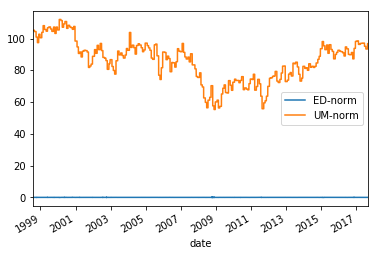

-0.0044340575356823352

In [38]:
# assigning sector db to graph db
graph = indic_utilities[['ED','UMCSENT']].dropna(how='any')

# --- normalizing data - method 1 ---
# graph['ED-norm'] = (graph['ED']-graph['ED'].mean())/graph['ED'].std()
# graph['UM-norm'] = (graph['UMCSENT']-graph['UMCSENT'].mean())/graph['UMCSENT'].std()

# --- normalizing data - method 2 ---
# graph['ED-norm'] = np.log(graph['ED'])
# graph['UM-norm'] = graph['UMCSENT']

# --- normalizing data - method 3 ---
graph['ED-norm'] = graph['ED'].pct_change()
graph['UM-norm'] = graph['UMCSENT']

# displaying data
list = ['ED-norm','UM-norm']
graph.plot(kind='line',y=list)
plt.show()

graph['ED-norm'].corr(graph['UM-norm'])

# graph = indic_utilities[['ED','UNRATENSA']].dropna(how='any').pct_change()
# list = ['ED','UNRATENSA']
# graph.plot(kind='line',y=list)
# plt.show()

# graph['ED'].corr(graph['UNRATENSA'])

In [47]:
indic_utilities.columns

Index(['ED', 'SJW', 'SJI', 'DUK', 'D', 'MSEX', 'NJR', 'AVA', 'SO', 'VVC',
       'TGS', 'TAC', 'ORA', 'CZZ', 'NWE', 'EBR', 'PAM', 'SXE', 'HOUST',
       'UNRATENSA', 'EMRATIO', 'UEMPMED', 'UMCSENT', 'USSLIND', 'KCFSI',
       'IPMAN', 'VIXCLS', 'DGS10'],
      dtype='object')

In [133]:
# scipy module linear regression (Doesnt work)

# regression = indic_utilities.loc[:, 'ED':'SXE'].dropna(how='any').pct_change().dropna(how='any')

# normalizing the data (indicators are fitted and stocks are summed+per_change)
norm_indic = indic_utilities.copy()
norm_indic['sum'] = norm_indic.loc[:, 'ED':'SXE'].sum(axis=1).pct_change()
norm_indic = norm_indic[['sum','UNRATENSA']].dropna(how='any')

scaler = MinMaxScaler(feature_range=(0,1))
test = scaler.fit_transform(regression)

# running regression scipy
x = test[0][0]
y = test[0][1]

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print(r_value)
print(p_value)


# running regression scipy
x = regression['sum'].tolist()
y = regression['UNRATENSA'].tolist()

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print(r_value)
print(p_value)

print(stats.norm(regression['UNRATENSA']))

TypeError: object of type 'numpy.float64' has no len()

In [26]:
# smf module ols regression (Maybe works?)

ed_pc = indic_utilities['ED'].pct_change()
unr_pc = indic_utilities['UNRATENSA'].pct_change()
ols_model = smf.ols('ed_pc ~ unr_pc', ed_pc).fit()
print(ols_model.summary())

graph = indic_utilities[['ED','UMCSENT']].dropna(how='any')

                            OLS Regression Results                            
Dep. Variable:                  ed_pc   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06512
Date:                Sat, 24 Mar 2018   Prob (F-statistic):              0.799
Time:                        13:02:58   Log-Likelihood:                 5432.9
No. Observations:                1674   AIC:                        -1.086e+04
Df Residuals:                    1672   BIC:                        -1.085e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      2.272      0.0

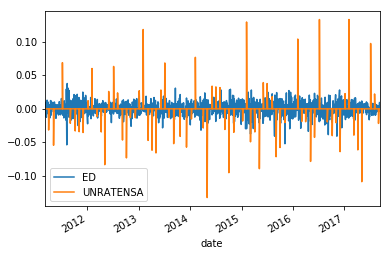

-0.0062404362608488506

In [34]:
# 